# Stock Price Predictions

We can also make testable predictions by restricting our model to a subset of the data, and then using the forecasted values to see how correct our model is. We will restrict data up until the end of 2016, and then try to make predictions for 2017.

In [38]:
import quandl 
import pandas as pd
import numpy as np
import fbprophet

import matplotlib.pyplot as plt
%matplotlib inline

## Retrieve Data from Quandl

In [12]:
quandl.ApiConfig.api_key = 'rFsSehe51RLzREtYhLfo'

# Using Tesla data
tesla_stocks = quandl.get('WIKI/TSLA')

In [13]:
# Set the index (with dates) to a column 
tesla_stocks.reset_index(level=0, inplace=True)

# Rename the columns for prophet and create a year column
tesla_stocks.rename(columns={'Date': 'ds', 'Adj. Close': 'y'}, inplace=True)
tesla_stocks['Year'] = [date.year for date in tesla_stocks['ds']]

In [14]:
tesla_stocks.head()

ds   Open     High    Low  Close      Volume  Ex-Dividend  \
0 2010-06-29  19.00  25.0000  17.54  23.89  18766300.0          0.0   
1 2010-06-30  25.79  30.4192  23.30  23.83  17187100.0          0.0   
2 2010-07-01  25.00  25.9200  20.27  21.96   8218800.0          0.0   
3 2010-07-02  23.00  23.1000  18.71  19.20   5139800.0          0.0   
4 2010-07-06  20.00  20.0000  15.83  16.11   6866900.0          0.0   

   Split Ratio  Adj. Open  Adj. High  Adj. Low      y  Adj. Volume  Year  
0          1.0      19.00    25.0000     17.54  23.89   18766300.0  2010  
1          1.0      25.79    30.4192     23.30  23.83   17187100.0  2010  
2          1.0      25.00    25.9200     20.27  21.96    8218800.0  2010  
3          1.0      23.00    23.1000     18.71  19.20    5139800.0  2010  
4          1.0      20.00    20.0000     15.83  16.11    6866900.0  2010

In [24]:
# Create a new dataframe with the relevant information
tesla_data = tesla_stocks[['ds', 'Year', 'y']]

# Training and testing data
tesla_train = tesla_data[tesla_data['Year'] < 2017]
tesla_test = tesla_data[tesla_data['Year'] > 2016]

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [31]:
# Create a new model 
tesla_prophet = fbprophet.Prophet(changepoint_prior_scale=0.2)

# Train the model
tesla_prophet.fit(tesla_train)

# Number of days to make predictions 
days = (max(tesla_test['ds']) - min(tesla_test['ds'])).days

# Future dataframe
tesla_forecast = tesla_prophet.make_future_dataframe(periods = days, freq = 'D')

# Make forecasts
tesla_forecast = tesla_prophet.predict(tesla_forecast)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [51]:
tesla_results = tesla_forecast.merge(tesla_test, how = 'inner', on = 'ds')
tesla_results = tesla_results[['ds', 'y', 'yhat']]

# Predicted difference between stock prices
tesla_results['pred_diff'] = (tesla_results['yhat']).diff()

# Actual difference between stock prices
tesla_results['real_diff'] = (tesla_results['y']).diff()

In [55]:
# Correct direction column
tesla_results['correct'] = (np.sign(tesla_results['pred_diff']) == np.sign(tesla_results['real_diff'])) * 1

In [56]:
tesla_results.head()

ds       y        yhat  pred_diff  real_diff  correct
0 2017-01-03  216.99  186.828281        NaN        NaN        0
1 2017-01-04  226.99  186.063539  -0.764742      10.00        0
2 2017-01-05  226.75  185.533523  -0.530017      -0.24        1
3 2017-01-06  229.01  184.832816  -0.700706       2.26        0
4 2017-01-09  231.28  183.398138  -1.434679       2.27        0

In [57]:
np.mean(tesla_results['correct'])

0.4823529411764706

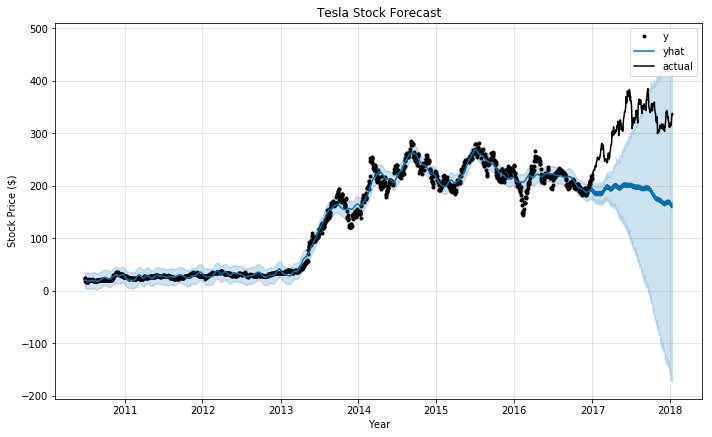

In [36]:
tesla_prophet.plot(tesla_forecast)
plt.title('Tesla Stock Forecast'); plt.ylabel('Stock Price ($)'); plt.xlabel('Year');
plt.plot(tesla_test['ds'], tesla_test['y'], 'k', label = 'actual')
plt.legend();

In [20]:
def stock_predictor(ticker='TSLA'):
    try:
        stock = quandl.get('WIKI/%s' % ticker)
    except Exception as e:
        print('Invalid Stock Ticker')
        print(e)
        return
    
    # Change the index to a Date column
    stock_clean = stock.reset_index()[['Date', 'Adj. Close']]
    # Create a year column
    stock_clean['Year'] = [date.year for date in stock_clean['Date']]
    
    # Training and Testing Sets
    stock_train = stock_clean[stock_clean['Year'] < 2017].rename(columns={'Date': 'ds', 'Adj. Close': 'y'})
    stock_test = stock_clean[stock_clean['Year'] > 2016]
    
    # Create the prophet model and fit on training set
    stock_prophet = fbprophet.Prophet(changepoint_prior_scale=0.15)
    stock_prophet.fit(stock_train)
    
    # Number of days to predict
    days = (max(stock_test['ds']) - min(stock_test['ds'])).days
    
    # Make forecasts for entire length of test set + one week
    stock_forecast = stock_prophet.make_future_dataframe(periods=days, freq = 'D')
    stock_forecast = stock_prophet.predict(stock_forecast)
    
    # Plot the entire series
    stock_prophet.plot(stock_forecast); plt.xlabel('Year'); plt.ylabel('Price (US $)');
    plt.title('%s Stock Price and Predictions' % ticker)
    
    
    # Dataframe for predictions and test values
    results = stock_forecast[['ds', 'yhat', 'trend', 'seasonal', 'seasonalities', 'weekly', 'yearly', 'yhat_upper', 'yhat_lower']]
    results = pd.merge(results, stock_test[['Date', 'Adj. Close']], left_on='ds', right_on='Date', how='right')
    
    all_pred = results[['trend', 'seasonal', 'seasonalities', 'weekly', 'yearly']]
    # results['yhat'] = list(np.sum(np.array(all_pred), axis=1))
    
    
    xvalues = list(range(len(results['Date'])))

    xlabels = list(range(13))
    xlabels.append(1)
    
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 8));
    ax.plot(xvalues, results['Adj. Close'], 'b-', label = 'Actual');
    ax.plot(xvalues, results['yhat'], 'r*', label = 'Predicted');
    ax.fill_between(xvalues, results['yhat_upper'], results['yhat_lower'], alpha=0.6, edgecolor = 'k');
    ax.set_xticks(ticks = list(range(0, max(xvalues), int(max(xvalues) / 12))));
    ax.set_xticklabels(labels = xlabels);
    plt.legend();
    plt.xlabel('2017'); plt.ylabel('Billions $'); plt.title('Stock Price Prediction for %s' % ticker)
    plt.show()
                  
    # Columns of daily changes
    results['pred_diff'] = results['yhat'].diff()
    results['actual_diff'] = results['Adj. Close'].diff()
    
    # Whether the prediction was right or wrong
    results['pred_right'] = np.array((np.sign(results['pred_diff']) == np.sign(results['actual_diff'])).astype('int')).astype(int)
    
    plt.figure(figsize = (10, 8))
    plt.plot(results['Date'], results['actual_diff'], 'bo-', label = 'Actual')
    plt.plot(results['Date'], results['pred_diff'], 'r*-', label = 'Predicted')
    plt.legend(); plt.xlabel('Date'); plt.ylabel('Change (US $)'); plt.title('Actual vs. Predicted Daily Change');
    plt.show();
    
    # Percentage of time direction lined up
    direction_accuracy = np.mean(results['pred_right'])
                                         
    # Performance metrics
    errors = abs(results['yhat'] - results['Adj. Close'])
    mean_error = np.mean(errors)
    mape = np.mean(errors / results['Adj. Close'])
    accuracy = 100 - (100 * mape)
    
    print('Actual and Predicted Difference Aligned {:0.2f}%.'.format(direction_accuracy * 100))
    
    performance = {'error': mean_error, 'accuracy': accuracy, 'dir_acc': direction_accuracy, 'predictions': results}
    return performance